In [1]:
import torch
import os
from PIL import Image 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optimize
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import torchvision.transforms as Trans
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
img_path = '../input/wheat-growth-ds/Images'
train_labels = pd.read_csv('../input/wheat-growth-ds/Train.csv')
test_labels = pd.read_csv('../input/wheat-growth-ds/SampleSubmission.csv')

In [3]:
train_labels.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1


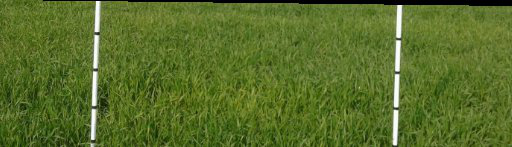

In [4]:
Image.open(os.path.join('{}/{}.jpeg'.format(img_path,'nwuCTQKz')))

In [5]:
class Img_dataset(Dataset):
    def __init__(self, imgroot, csv_file, transform=None):
        super().__init__()
        self.file = csv_file
        self.root = imgroot
        self.transform  = transform
        
    def __len__(self):
        return len(self.file)
    

    def __getitem__(self, idx):
        row = self.file.loc[idx]
        imgid_, label_ = row['UID'], row['growth_stage']
        img_ = Image.open(os.path.join('{}/{}.jpeg'.format(self.root,imgid_))).convert('RGB')
        if self.transform != None:
            img_ = self.transform(img_)
        return img_,label_

In [6]:
channel_size = 3
img_height = 224
img_width = 224

In [7]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    Trans.Compose([
        Trans.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        Trans.RandomRotation(degrees=15),
        Trans.ColorJitter(),
        Trans.RandomHorizontalFlip(),
        Trans.CenterCrop(size=224), # Image net standards
        Trans.ToTensor(),
       # Trans.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225]) # Imagenet standards
    ]),
#     # Validation does not use augmentation
#     'valid':
#     Trans.Compose([
#         Trans.Resize(size=256),
#         Trans.CenterCrop(size=224),
#         Trans.ToTensor(),
#         Trans.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#     ]),

        # Test does not use augmentation
    'test':
    Trans.Compose([
        Trans.Resize(size=256),
        Trans.CenterCrop(size=224),
        Trans.ToTensor(),
       # Trans.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [8]:
# transforms = Trans.Compose([
#     #Trans.Grayscale(num_output_channels=1), 
#     Trans.Resize(img_height),
#     Trans.CenterCrop(img_height),
#     #Trans.RandomCrop(),
#     #Trans.ColorJitter(brightness = 1),
#     Trans.ToTensor(),
#     Trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )])

In [9]:
train_ds = Img_dataset(img_path,train_labels ,transform=image_transforms['train'])
len(train_ds)

10695

In [10]:
# val_ds = Img_dataset(img_path,train_labels[9500:] ,transform=image_transforms['valid'])
# len(val_ds)

In [11]:
test_ds = Img_dataset(img_path,test_labels ,transform=image_transforms['test'])
print(len(test_ds))
test_ds[0][0].size()

3558


torch.Size([3, 224, 224])

In [12]:
 def show_samples(im, lab ):
    img_,label_ = im, lab
    print(label_)
    plt.imshow(np.transpose(img_))

4


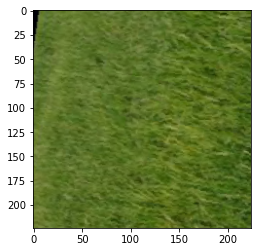

In [13]:
show_samples(*train_ds[0])

5


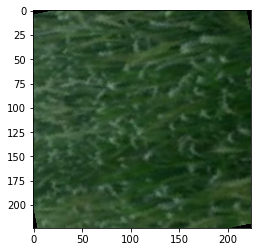

In [14]:
show_samples(*train_ds[100])

In [15]:
torch.manual_seed(42)
#np.random.seed(42)

In [16]:
#split into train_ds and val_ds
train_ds , val_ds = random_split(train_ds,[9500, 1195])

#create train, val and test dataloader
batch_size = 128
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds , batch_size)
test_dl = DataLoader(test_ds)

images shapes: torch.Size([128, 3, 224, 224])
images ndim: 4
labels shapes: torch.Size([128])


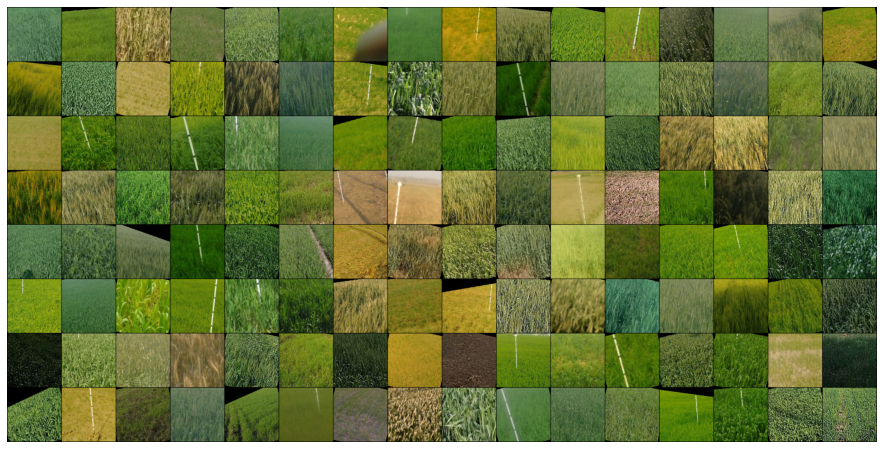

In [17]:
#display batch of images using make_grid
for img_b,lab_b in train_dl:
    print('images shapes:',img_b.shape)
    print('images ndim:',img_b.ndim)
    print('labels shapes:',lab_b.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    #plt.imshow(np.transpose(make_grid(img_b , nrow=20),(1,2,0)))
    plt.imshow(make_grid(img_b, nrow=16).permute((1, 2, 0)))
    break

In [18]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [19]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
n_classes = 7
n_inputs = 224*224*3
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 390),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(390, n_classes),
                      nn.LogSoftmax(dim=1))

In [22]:
#check if GPU is present
USE_GPU = torch.cuda.is_available()
USE_GPU

True

In [23]:
def get_default_device():
    '''helper function to help in reproducibility 
    to return cuda device if true and cpu if false'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
def to_device(data, device):
    '''Helper function to move data, model,
    or any tensor excluding dataloaders to device(cpu/cuda)'''
    if isinstance(data,(list , tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device , non_blocking=True)

In [26]:
#how to supply data from data loaders to cuda 
for _img, _lab in train_dl:
    print(_img.shape)
    _img = to_device(_img , device)
    print(_img)
    #checking type of device on which data is on 
    print(_img.device)
    break

torch.Size([128, 3, 224, 224])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [

In [27]:
class DeviceDataLoader():
    '''wrap a dataloader to move to device'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        '''Yield a batch of data after moving to device'''
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len__(self):
        '''Number of batches'''
        return len(self.dl)

In [28]:
#send dl to available device (cpu or cuda) using DeviceDataLoader class
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [29]:
#move instantiated model to current available device using to_device
to_device(model , device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
for _img,_lab in train_dl:
    print('device in use:',_img.device )
    print(_lab)
    break

device in use: cuda:0
tensor([4, 5, 7, 7, 2, 4, 1, 2, 4, 6, 7, 3, 7, 1, 3, 1, 5, 2, 5, 1, 5, 1, 7, 6,
        3, 5, 4, 2, 7, 1, 7, 1, 1, 1, 7, 4, 7, 7, 4, 6, 4, 4, 1, 4, 7, 1, 1, 7,
        2, 2, 7, 5, 2, 6, 4, 1, 7, 4, 1, 4, 3, 3, 7, 3, 1, 3, 7, 5, 1, 1, 5, 4,
        7, 1, 1, 2, 2, 2, 7, 1, 1, 7, 3, 4, 2, 1, 1, 6, 1, 1, 7, 5, 6, 2, 4, 1,
        1, 4, 5, 4, 1, 7, 1, 7, 1, 1, 2, 4, 2, 1, 7, 2, 1, 6, 1, 3, 2, 1, 5, 7,
        7, 4, 4, 2, 4, 4, 4, 1], device='cuda:0')


In [31]:
def acc_score(outs_ ,labels_):
    # evaluate model
    maxprobs , preds_ = torch.max(outs_, dim=1)
    return torch.tensor(torch.sum(preds_ == labels_).item() / len(labels_))

In [32]:
# def evaluate_model(model, dl):
#     return model.epoch_end([model.validation_step(batch_) for batch_ in dl])

In [33]:
F.cross_entropy?

In [34]:
class WheatBaseModel(nn.Module):
    def training_step(self, batch, alpha=1, gamma=2):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets,ignore_index=7)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, targets,ignore_index=7)  # Calculate loss
        score = acc_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

#num_ftrs=224*224*3

#resnet18 = models.resnet18()

class WheatResnet(WheatBaseModel):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 7)
    
    def forward(self, xb):
        return  F.softmax(self.network(xb), dim=1)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


In [35]:
import copy

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
model = to_device(WheatResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [38]:
#First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.
model.freeze()

In [39]:
#test acc_score function 
for inputs, targets in train_dl:
    # evaluate the model on the test set
    yhat = model(inputs)
    print(acc_score(yhat ,targets))
    break

tensor(0.0703)


In [40]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.937709093093872, 'val_score': 0.1054142490029335}]

In [41]:
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0001, train_loss: 1.6660, val_loss: 1.5805, val_score: 0.4519



Epoch [1], last_lr: 0.0003, train_loss: 1.5907, val_loss: 1.6249, val_score: 0.4191



Epoch [2], last_lr: 0.0005, train_loss: 1.6274, val_loss: 1.6552, val_score: 0.3895



Epoch [3], last_lr: 0.0008, train_loss: 1.6229, val_loss: 1.6057, val_score: 0.4363



Epoch [4], last_lr: 0.0009, train_loss: 1.6271, val_loss: 1.6789, val_score: 0.3715



Epoch [5], last_lr: 0.0010, train_loss: 1.6293, val_loss: 1.6124, val_score: 0.4245



Epoch [6], last_lr: 0.0010, train_loss: 1.6319, val_loss: 1.7567, val_score: 0.3129



Epoch [7], last_lr: 0.0010, train_loss: 1.6262, val_loss: 1.6338, val_score: 0.4090



Epoch [8], last_lr: 0.0009, train_loss: 1.6109, val_loss: 1.6071, val_score: 0.4261



Epoch [9], last_lr: 0.0008, train_loss: 1.6007, val_loss: 1.6007, val_score: 0.4308



Epoch [10], last_lr: 0.0007, train_loss: 1.6054, val_loss: 1.6047, val_score: 0.4309



Epoch [11], last_lr: 0.0006, train_loss: 1.6037, val_loss: 1.5849, val_score: 0.4457



Epoch [12], last_lr: 0.0005, train_loss: 1.5914, val_loss: 1.5800, val_score: 0.4503



Epoch [13], last_lr: 0.0004, train_loss: 1.5822, val_loss: 1.5728, val_score: 0.4512



Epoch [14], last_lr: 0.0003, train_loss: 1.5791, val_loss: 1.5627, val_score: 0.4597



Epoch [15], last_lr: 0.0002, train_loss: 1.5721, val_loss: 1.5537, val_score: 0.4691



Epoch [16], last_lr: 0.0001, train_loss: 1.5652, val_loss: 1.5463, val_score: 0.4738



Epoch [17], last_lr: 0.0000, train_loss: 1.5573, val_loss: 1.5462, val_score: 0.4753



Epoch [18], last_lr: 0.0000, train_loss: 1.5550, val_loss: 1.5442, val_score: 0.4769



Epoch [19], last_lr: 0.0000, train_loss: 1.5555, val_loss: 1.5469, val_score: 0.4745
CPU times: user 20min 17s, sys: 4min 16s, total: 24min 33s
Wall time: 25min 50s


In [44]:
torch.save(model.state_dict(), 'baseline_modelcudapretrain0.pth')
model.load_state_dict(torch.load('./baseline_modelcudapretrain0.pth'))

<All keys matched successfully>

In [43]:
12

12

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.01, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [59]:
# history_metrics = [evaluate_model(model, val_dl)]
# history_metrics

In [61]:
# history += fit(100, model, train_dl, val_dl,  0.001, opt_func= optimize.SGD)

NameError: name 'fit' is not defined

Text(0.5, 1.0, 'loss per epoch')

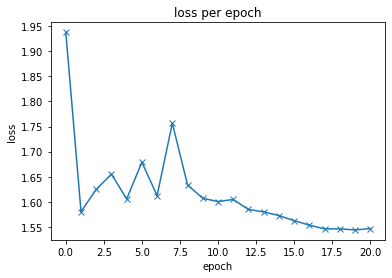

In [46]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

#list of losses
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss per epoch')

Text(0.5, 1.0, 'acc per epoch')

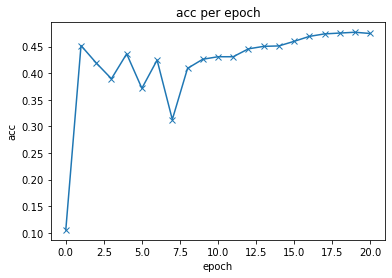

In [48]:
#list of accs
accs = [x['val_score'] for x in history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc per epoch')

In [ ]:
def try_prediction(model, val_):
    for xx,yy in val_:
        pred = model(xx)
        print(yy)
        _,p = torch.max(pred , dim=-1)
        print(p == yy)
        return acc_score(pred,yy)
try_prediction(cudamodel, val_dl)

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = cudamodel(xb)
    prediction = preds
    print(prediction)
    _,p = torch.max(prediction , dim=-1)
    print(_)
    print("Prediction: ",p)

In [ ]:
1.0000e+00 - 4.5382e-41

In [ ]:
for i , v in train_dl:
    predict_single(i)
    print('True',v)
    #show_samples(i.cpu(), v)
    break

In [ ]:
for bx,by in val_dl:
    x = cudamodel(bx)
    _,p = torch.max(x , dim=-1)
    print(torch.sum(by== p))
    break

In [49]:
predictio = []    
for inputs, targets in test_dl:
    # evaluate the model on the test set
    yhat = model(inputs)
    maxprobs ,preds_ = torch.max(yhat, dim=1)
    predictio.append(preds_.item())

In [ ]:
predictio.count(0)

In [ ]:
maxprobs

In [50]:
preds_

tensor([1], device='cuda:0')

In [51]:
len(predictio)

3558

In [52]:
predictio[0:11]

[4, 4, 1, 4, 4, 3, 3, 2, 4, 3, 3]

In [ ]:
test_labels['growth_stage'] = predictio
test_labels.to_csv('resnet34_pred0.csv' ,index=False )

In [ ]:
test_labels['growth_stage'].unique()